# OLS Regression Model - Statistical Analysis and Interpretation

## Strategy:
- Focus on statistical interpretation and business meaning
- Comprehensive OLS diagnostics with clear explanations
- Test meaningful feature combinations based on preprocessing insights
- Emphasize coefficient interpretation for power plant operations

In [ ]:
# Load preprocessing results from preprocessing.ipynb
%run preprocessing.ipynb
print("Preprocessing complete. Data ready for OLS modeling.")
print(f"Loaded variables: data, features, target, X_standardized")
print(f"Data shape: {data.shape}")
print(f"Features: {features}")
print(f"Target: {target}")

In [77]:
# PHASE 1: ASSUMPTION TESTING & DIAGNOSTICS
# ============================================
# Rigorous statistical validation before model fitting

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("PHASE 1: COMPREHENSIVE OLS ASSUMPTION TESTING")
print("=" * 50)

# Prepare data for analysis
X = data[features]
y = data[target]

# Train-test split for validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

# Use standardized features (essential for condition number analysis)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)

print(f"Training set: {X_train_scaled.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\n1. LINEARITY ASSUMPTION TESTING")
print("-" * 30)

# Test 1: RESET Test for Functional Form
print("RESET Test for Functional Form Specification:")
print("H0: Linear functional form is adequate")
print("H1: Non-linear terms are needed")

# Fit basic linear model for RESET test
X_with_const = sm.add_constant(X_train_scaled)
model_basic = sm.OLS(y_train, X_with_const).fit(cov_type='HC3')  # Use HC3 directly in fit

# Manual RESET test using fitted values - Fix the calculation
y_fitted = model_basic.fittedvalues
y_fitted_sq = y_fitted ** 2
y_fitted_cube = y_fitted ** 3

# Augmented regression with powers of fitted values
X_reset = X_with_const.copy()
X_reset['fitted_sq'] = y_fitted_sq
X_reset['fitted_cube'] = y_fitted_cube

model_reset = sm.OLS(y_train, X_reset).fit()

# Correct F-test calculation
k = len(features)  # Number of original variables
n = len(y_train)   # Sample size
ssr_restricted = model_basic.ssr
ssr_unrestricted = model_reset.ssr

# F-statistic for adding 2 terms (fitted^2 and fitted^3)
f_stat = ((ssr_restricted - ssr_unrestricted) / 2) / (ssr_unrestricted / (n - k - 3))
f_pvalue = 1 - stats.f.cdf(f_stat, 2, n - k - 3)

print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {f_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Non-linearity detected' if f_pvalue < 0.05 else 'FAIL TO REJECT H0 - Linear form adequate'}")

print(f"\n2. MULTICOLLINEARITY DIAGNOSTICS")
print("-" * 30)

# Calculate VIF for all features
print("Variance Inflation Factors (VIF):")
print("Interpretation: VIF > 5 indicates problematic multicollinearity")
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) 
                   for i in range(len(X_train_scaled.columns))]

for _, row in vif_data.iterrows():
    status = "PROBLEMATIC" if row['VIF'] > 5 else "ACCEPTABLE" if row['VIF'] > 2 else "EXCELLENT"
    print(f"{row['Feature']:20s}: {row['VIF']:6.2f} ({status})")

# Condition Number Analysis
print(f"\nCondition Number Analysis:")
cond_num = np.linalg.cond(X_with_const)
print(f"Condition Number: {cond_num:.2f}")
print(f"Interpretation: {('EXCELLENT' if cond_num < 10 else 'GOOD' if cond_num < 30 else 'PROBLEMATIC')} numerical stability")

# Eigenvalue analysis
eigenvals = np.linalg.eigvals(X_train_scaled.corr())
print(f"Smallest eigenvalue: {eigenvals.min():.6f}")
print(f"Eigenvalue ratio: {eigenvals.max()/eigenvals.min():.2f}")

print(f"\n3. RESIDUAL NORMALITY TESTING")
print("-" * 30)

# Note: We test RESIDUAL normality, not predictor normality
residuals = model_basic.resid

# Jarque-Bera test - use scipy version which returns 2 values
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print("Jarque-Bera Test for Residual Normality:")
print("H0: Residuals are normally distributed")
print(f"Test statistic: {jb_stat:.4f}")
print(f"p-value: {jb_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Non-normal residuals' if jb_pvalue < 0.05 else 'FAIL TO REJECT H0 - Normal residuals'}")

# Shapiro-Wilk test (more powerful for small samples)
if len(residuals) <= 5000:
    sw_stat, sw_pvalue = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test:")
    print(f"Test statistic: {sw_stat:.4f}")
    print(f"p-value: {sw_pvalue:.4f}")
    print(f"Result: {'REJECT H0 - Non-normal residuals' if sw_pvalue < 0.05 else 'FAIL TO REJECT H0 - Normal residuals'}")

print(f"\n4. HETEROSCEDASTICITY TESTING")
print("-" * 30)

# Breusch-Pagan test
bp_stat, bp_pvalue, f_stat_bp, f_pvalue_bp = het_breuschpagan(residuals, X_with_const)
print("Breusch-Pagan Test for Heteroscedasticity:")
print("H0: Homoscedasticity (constant variance)")
print("H1: Heteroscedasticity (non-constant variance)")
print(f"LM statistic: {bp_stat:.4f}")
print(f"p-value: {bp_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Heteroscedasticity detected' if bp_pvalue < 0.05 else 'FAIL TO REJECT H0 - Homoscedasticity'}")

# White test (more general)
white_stat, white_pvalue, white_f, white_f_pvalue = het_white(residuals, X_with_const)
print(f"\nWhite Test for Heteroscedasticity:")
print(f"LM statistic: {white_stat:.4f}")
print(f"p-value: {white_pvalue:.4f}")
print(f"Result: {'REJECT H0 - Heteroscedasticity detected' if white_pvalue < 0.05 else 'FAIL TO REJECT H0 - Homoscedasticity'}")

print(f"\n5. AUTOCORRELATION TESTING")
print("-" * 30)

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Test for Autocorrelation:")
print("H0: No autocorrelation (independent residuals)")
print(f"DW statistic: {dw_stat:.4f}")
print("Interpretation:")
if dw_stat < 1.5:
    print("- Strong positive autocorrelation detected")
elif dw_stat > 2.5:
    print("- Strong negative autocorrelation detected")  
else:
    print("- No significant autocorrelation")

print(f"\n" + "="*60)
print("DEEP RESIDUAL DIAGNOSTICS - INVESTIGATING VIOLATIONS")
print("="*60)

# Calculate fitted values and residuals for diagnostic plots
fitted_values = model_basic.fittedvalues
standardized_residuals = residuals / np.sqrt(model_basic.mse_resid)
studentized_residuals = residuals / np.sqrt(model_basic.mse_resid * (1 - model_basic.get_influence().hat_matrix_diag))

print("6. RESIDUAL PATTERN ANALYSIS")
print("-" * 30)

# Analyze residual distribution characteristics
print("Residual Distribution Characteristics:")
print(f"Mean: {residuals.mean():.6f} (should be ≈ 0)")
print(f"Std Dev: {residuals.std():.4f}")
print(f"Skewness: {stats.skew(residuals):.4f} (normal = 0)")
print(f"Kurtosis: {stats.kurtosis(residuals):.4f} (normal = 0)")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

# Check for specific non-normality patterns
print(f"\nNon-normality Analysis:")
if abs(stats.skew(residuals)) > 0.5:
    skew_dir = "right" if stats.skew(residuals) > 0 else "left"
    print(f"- Significant {skew_dir} skewness detected")
if stats.kurtosis(residuals) > 1:
    print(f"- Heavy tails detected (excess kurtosis)")
elif stats.kurtosis(residuals) < -1:
    print(f"- Light tails detected (negative excess kurtosis)")

print(f"\n7. OUTLIER AND INFLUENCE DIAGNOSTICS")
print("-" * 40)

# Calculate influence measures
influence = model_basic.get_influence()
cook_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag
dffits = influence.dffits[0]

# Identify potential outliers
n_params = len(model_basic.params)
cook_threshold = 4 / len(residuals)
leverage_threshold = 2 * n_params / len(residuals)
studentized_threshold = 2

high_cook = np.sum(cook_d > cook_threshold)
high_leverage = np.sum(leverage > leverage_threshold)
high_studentized = np.sum(np.abs(studentized_residuals) > studentized_threshold)

print(f"Outlier Detection Thresholds:")
print(f"Cook's Distance > {cook_threshold:.4f}: {high_cook} observations")
print(f"Leverage > {leverage_threshold:.4f}: {high_leverage} observations")
print(f"Studentized Residuals > {studentized_threshold}: {high_studentized} observations")

print(f"\nMost Influential Observations:")
top_cook_idx = np.argsort(cook_d)[-5:][::-1]
for i, idx in enumerate(top_cook_idx, 1):
    print(f"{i}. Obs {idx}: Cook's D={cook_d[idx]:.4f}, Leverage={leverage[idx]:.4f}, Resid={residuals.iloc[idx]:.2f}")

print(f"\n8. HETEROSCEDASTICITY PATTERN ANALYSIS")
print("-" * 45)

# Analyze if heteroscedasticity is systematic
fitted_terciles = pd.qcut(fitted_values, 3, labels=['Low', 'Medium', 'High'])
print("Residual variance by fitted value terciles:")
for tercile in ['Low', 'Medium', 'High']:
    tercile_residuals = residuals[fitted_terciles == tercile]
    variance = tercile_residuals.var()
    print(f"{tercile:6s} fitted values: Residual variance = {variance:.4f}")

# Test for specific heteroscedasticity patterns
print(f"\nHeteroscedasticity Pattern Analysis:")
fitted_resid_corr = np.corrcoef(fitted_values, np.abs(residuals))[0, 1]
print(f"Correlation(|Residuals|, Fitted): {fitted_resid_corr:.4f}")
if abs(fitted_resid_corr) > 0.3:
    pattern = "increasing" if fitted_resid_corr > 0 else "decreasing"
    print(f"- {pattern.title()} variance pattern detected")

print(f"\n9. BOX-COX TRANSFORMATION ANALYSIS")
print("-" * 40)

# Test if transformation could help with normality/heteroscedasticity
print("Testing if power transformation could improve model:")

# Box-Cox test on response variable
if y_train.min() > 0:  # Box-Cox requires positive values
    from scipy.stats import boxcox
    try:
        transformed_y, lambda_opt = boxcox(y_train)
        print(f"Optimal Box-Cox lambda: {lambda_opt:.4f}")
        
        if abs(lambda_opt - 1) < 0.1:
            print("- No transformation needed (λ ≈ 1)")
        elif abs(lambda_opt - 0.5) < 0.1:
            print("- Square root transformation suggested (λ ≈ 0.5)")
        elif abs(lambda_opt) < 0.1:
            print("- Logarithmic transformation suggested (λ ≈ 0)")
        else:
            print(f"- Power transformation y^{lambda_opt:.2f} suggested")
            
    except Exception as e:
        print(f"Box-Cox analysis failed: {str(e)}")
else:
    print("Box-Cox analysis not applicable (negative values present)")

print(f"\n" + "="*60)
print("DIAGNOSTIC SUMMARY & STATISTICAL IMPLICATIONS")
print("="*60)

print("ASSUMPTION VIOLATIONS DETECTED:")
print("-" * 35)

violations = []
if jb_pvalue < 0.05:
    violations.append("Non-normal residuals")
if bp_pvalue < 0.05:
    violations.append("Heteroscedasticity")
if any(vif_data["VIF"] > 5):
    violations.append("Multicollinearity")
if dw_stat < 1.5 or dw_stat > 2.5:
    violations.append("Autocorrelation")

for i, violation in enumerate(violations, 1):
    print(f"{i}. {violation}")

print(f"\nCOEFFICIENT RELIABILITY IMPLICATIONS:")
print("-" * 40)
print("✓ Point estimates: Unbiased (OLS property maintained)")
print("✗ Standard errors: Potentially incorrect due to heteroscedasticity")
print("✗ t-statistics: Invalid for hypothesis testing")
print("✗ Confidence intervals: Incorrect coverage probability")
print("✗ F-statistic: Invalid for overall model significance")

print(f"\nREQUIRED REMEDIAL ACTIONS:")
print("-" * 30)
print("1. Use robust standard errors (HC3) for heteroscedasticity")
print("2. Consider bootstrap confidence intervals for non-normal residuals")
print("3. Apply Box-Cox transformation if λ significantly ≠ 1")
print("4. Report both regular and robust statistics")
print("5. Focus on model combinations with lower VIF for interpretation")

PHASE 1: COMPREHENSIVE OLS ASSUMPTION TESTING
Training set: 7621 samples
Test set: 1906 samples

1. LINEARITY ASSUMPTION TESTING
------------------------------
RESET Test for Functional Form Specification:
H0: Linear functional form is adequate
H1: Non-linear terms are needed
F-statistic: 417.7905
p-value: 0.0000
Result: REJECT H0 - Non-linearity detected

2. MULTICOLLINEARITY DIAGNOSTICS
------------------------------
Variance Inflation Factors (VIF):
Interpretation: VIF > 5 indicates problematic multicollinearity
ambient_temp        :   5.89 (PROBLEMATIC)
vacuum              :   3.87 (ACCEPTABLE)
ambient_pressure    :   1.46 (EXCELLENT)
relative_humidity   :   1.71 (EXCELLENT)

Condition Number Analysis:
Condition Number: 4.83
Interpretation: EXCELLENT numerical stability
Smallest eigenvalue: 0.104216
Eigenvalue ratio: 23.32

3. RESIDUAL NORMALITY TESTING
------------------------------
Jarque-Bera Test for Residual Normality:
H0: Residuals are normally distributed
Test statistic: 312

In [78]:
# PHASE 2: COMPREHENSIVE MODEL ANALYSIS - ALL COMBINATIONS
# =========================================================
# Test all 15 possible variable combinations systematically

from itertools import combinations
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

print("PHASE 2: SYSTEMATIC ALL-COMBINATIONS ANALYSIS")
print("=" * 50)

# Generate all possible combinations (1 to 4 variables)
all_combinations = []
for r in range(1, len(features) + 1):
    for combo in combinations(features, r):
        all_combinations.append(list(combo))

print(f"Testing {len(all_combinations)} variable combinations:")
for i, combo in enumerate(all_combinations, 1):
    print(f"{i:2d}. {combo}")

print(f"\nSystematic Model Evaluation:")
print("=" * 30)

# Store results for comprehensive analysis
results_comprehensive = []

# 10-fold cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for combo_idx, feature_combo in enumerate(all_combinations, 1):
    combo_name = " + ".join(feature_combo)
    
    # Prepare data with individual scaler for this combination
    X_combo = X_train[feature_combo]
    
    # Create individual scaler for this feature combination
    combo_scaler = StandardScaler()
    X_combo_scaled = pd.DataFrame(
        combo_scaler.fit_transform(X_combo), 
        columns=X_combo.columns, 
        index=X_combo.index
    )
    
    X_combo_with_const = sm.add_constant(X_combo_scaled)
    
    # Fit OLS model 
    model = sm.OLS(y_train, X_combo_with_const).fit()
    model_robust = model.get_robustcov_results(cov_type='HC3')  # White standard errors
    
    # Calculate performance metrics
    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    aic = model.aic
    bic = model.bic
    
    # Test predictions using the same scaler
    X_test_combo = X_test[feature_combo]
    X_test_combo_scaled = pd.DataFrame(
        combo_scaler.transform(X_test_combo), 
        columns=X_test_combo.columns, 
        index=X_test_combo.index
    )
    X_test_combo_with_const = sm.add_constant(X_test_combo_scaled)
    y_pred_test = model.predict(X_test_combo_with_const)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Cross-validation R²
    lr_cv = LinearRegression()
    cv_scores = cross_val_score(lr_cv, X_combo_scaled, y_train, cv=kf, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # VIF calculation (for models with >1 variable)
    if len(feature_combo) > 1:
        vif_values = [variance_inflation_factor(X_combo_scaled.values, i) for i in range(len(feature_combo))]
        max_vif = max(vif_values)
        mean_vif = np.mean(vif_values)
    else:
        vif_values = [1.0]
        max_vif = 1.0
        mean_vif = 1.0
    
    # Statistical significance using original model (not robust)
    all_significant = all(model_robust.pvalues[1:] < 0.05)  # Exclude intercept
    
    # Extract coefficients using proper indexing
    coefficients = {}
    param_names = X_combo_with_const.columns.tolist()
    
    for i, feature in enumerate(feature_combo):
        if feature in param_names:
            param_idx = param_names.index(feature)
            coef_val = model_robust.params[param_idx]
            coef_se = model_robust.bse[param_idx] 
            coef_pval = model_robust.pvalues[param_idx] 
            coefficients[feature] = {
                'coef': coef_val,
                'se': coef_se,
                'pvalue': coef_pval,
                'significant': coef_pval < 0.05
            }
    
    # Store comprehensive results
    result = {
        'combination_id': combo_idx,
        'features': feature_combo,
        'feature_names': combo_name,
        'n_features': len(feature_combo),
        'r2': r2,
        'adj_r2': adj_r2,
        'test_r2': test_r2,
        'cv_r2_mean': cv_mean,
        'cv_r2_std': cv_std,
        'aic': aic,
        'bic': bic,
        'max_vif': max_vif,
        'mean_vif': mean_vif,
        'all_significant': all_significant,
        'coefficients': coefficients,
        'model_object': model_robust,
        'scaler': combo_scaler  # Store scaler for later use
    }
    
    results_comprehensive.append(result)
    
    # Progress indicator
    print(f"✓ Model {combo_idx:2d}/15: {combo_name:40s} | R²={r2:.4f} | CV={cv_mean:.4f}±{cv_std:.3f}")

# Convert to DataFrame for easy analysis
results_df = pd.DataFrame([{
    'Model': f"M{r['combination_id']:02d}",
    'Features': r['feature_names'],
    'N_Vars': r['n_features'],
    'R²': r['r2'],
    'Adj_R²': r['adj_r2'],
    'Test_R²': r['test_r2'],
    'CV_R²': r['cv_r2_mean'],
    'CV_Std': r['cv_r2_std'],
    'AIC': r['aic'],
    'BIC': r['bic'],
    'Max_VIF': r['max_vif'],
    'All_Sig': r['all_significant']
} for r in results_comprehensive])

print(f"\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Sort by different criteria
print(f"\n1. TOP MODELS BY CROSS-VALIDATION R²:")
print("-" * 40)
top_cv = results_df.nlargest(8, 'CV_R²')[['Model', 'Features', 'CV_R²', 'CV_Std', 'Max_VIF', 'All_Sig']]
for _, row in top_cv.iterrows():
    sig_icon = "✓" if row['All_Sig'] else "✗"
    vif_status = "OK" if row['Max_VIF'] < 5 else "HIGH"
    print(f"{row['Model']}: {row['CV_R²']:.4f}±{row['CV_Std']:.3f} | VIF:{vif_status:4s} | Sig:{sig_icon} | {row['Features']}")

print(f"\n2. BEST MODELS BY MODEL SELECTION CRITERIA:")
print("-" * 45)
best_aic = results_df.loc[results_df['AIC'].idxmin()]
best_bic = results_df.loc[results_df['BIC'].idxmin()]
best_adj_r2 = results_df.loc[results_df['Adj_R²'].idxmax()]

print(f"Best AIC:     {best_aic['Model']} | AIC={best_aic['AIC']:.1f} | {best_aic['Features']}")
print(f"Best BIC:     {best_bic['Model']} | BIC={best_bic['BIC']:.1f} | {best_bic['Features']}")
print(f"Best Adj R²:  {best_adj_r2['Model']} | R²={best_adj_r2['Adj_R²']:.4f} | {best_adj_r2['Features']}")

print(f"\n3. MODELS WITH EXCELLENT STATISTICAL PROPERTIES:")
print("-" * 50)
excellent_models = results_df[(results_df['Max_VIF'] < 3) & (results_df['All_Sig'] == True)]
if len(excellent_models) > 0:
    excellent_sorted = excellent_models.nlargest(5, 'CV_R²')[['Model', 'Features', 'CV_R²', 'Max_VIF']]
    for _, row in excellent_sorted.iterrows():
        print(f"{row['Model']}: {row['CV_R²']:.4f} | VIF={row['Max_VIF']:.2f} | {row['Features']}")
else:
    print("No models found with VIF < 3 and all significant coefficients")

print(f"\n4. PERFORMANCE DEGRADATION ANALYSIS:")
print("-" * 40)
full_model_cv = results_df[results_df['N_Vars'] == 4]['CV_R²'].iloc[0]
for n_vars in [3, 2, 1]:
    best_n = results_df[results_df['N_Vars'] == n_vars].nlargest(1, 'CV_R²').iloc[0]
    degradation = full_model_cv - best_n['CV_R²']
    print(f"Best {n_vars}-var model: {best_n['CV_R²']:.4f} | Loss: {degradation:.4f} | {best_n['Features']}")

PHASE 2: SYSTEMATIC ALL-COMBINATIONS ANALYSIS
Testing 15 variable combinations:
 1. ['ambient_temp']
 2. ['vacuum']
 3. ['ambient_pressure']
 4. ['relative_humidity']
 5. ['ambient_temp', 'vacuum']
 6. ['ambient_temp', 'ambient_pressure']
 7. ['ambient_temp', 'relative_humidity']
 8. ['vacuum', 'ambient_pressure']
 9. ['vacuum', 'relative_humidity']
10. ['ambient_pressure', 'relative_humidity']
11. ['ambient_temp', 'vacuum', 'ambient_pressure']
12. ['ambient_temp', 'vacuum', 'relative_humidity']
13. ['ambient_temp', 'ambient_pressure', 'relative_humidity']
14. ['vacuum', 'ambient_pressure', 'relative_humidity']
15. ['ambient_temp', 'vacuum', 'ambient_pressure', 'relative_humidity']

Systematic Model Evaluation:
✓ Model  1/15: ambient_temp                             | R²=0.8981 | CV=0.8979±0.009
✓ Model  2/15: vacuum                                   | R²=0.7530 | CV=0.7522±0.017
✓ Model  3/15: ambient_pressure                         | R²=0.2698 | CV=0.2680±0.027
✓ Model  4/15: relati

In [79]:
# PHASE 3: PROPER VARIANCE DECOMPOSITION & RELATIVE IMPORTANCE
# ============================================================
# Correct analysis of variable contributions and interactions

from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

print("PHASE 3: VARIANCE DECOMPOSITION ANALYSIS")
print("=" * 50)

# Extract R² values for all combinations
r2_dict = {}
for result in results_comprehensive:
    feature_key = tuple(sorted(result['features']))
    r2_dict[feature_key] = result['r2']

# Individual variable R²
r2_individual = {}
for feature in features:
    r2_individual[feature] = r2_dict[(feature,)]

print("1. INDIVIDUAL VARIABLE CONTRIBUTIONS:")
print("-" * 40)
for feature in features:
    r2_val = r2_individual[feature]
    print(f"{feature:20s}: R² = {r2_val:.4f} ({r2_val*100:.1f}%)")

print(f"\n2. PAIRWISE COMBINATION ANALYSIS:")
print("-" * 40)
print("Format: Variable1 + Variable2: R² = X.XXXX | Incremental = X.XXXX")
print("(Incremental = how much the second variable adds to the first)")
print()

for result in results_comprehensive:
    if len(result['features']) == 2:
        var1, var2 = result['features']
        pair_r2 = result['r2']

        # Calculate incremental contributions both ways
        incremental_1_to_2 = pair_r2 - r2_individual[var1]  # How much var2 adds to var1
        incremental_2_to_1 = pair_r2 - r2_individual[var2]  # How much var1 adds to var2

        print(f"{var1} + {var2:15s}: R² = {pair_r2:.4f} | {var2} adds {incremental_1_to_2:+.4f} to {var1}")
        print(f"{var2} + {var1:15s}: R² = {pair_r2:.4f} | {var1} adds {incremental_2_to_1:+.4f} to {var2}")
        print()

# Full model
r2_full = r2_dict[tuple(sorted(features))]
print(f"\n3. FULL MODEL ANALYSIS:")
print("-" * 30)
print(f"All four variables: R² = {r2_full:.4f}")

print(f"\n" + "="*60)
print("UNIQUE EFFECTS ANALYSIS (INCREMENTAL R² METHOD)")
print("="*60)
print("What each variable contributes that others cannot (order-independent)")
print()

# Calculate unique effects correctly using complementary sets
unique_effects = {}

for feature in features:
    # Unique effect = R²(full) - R²(without this feature)
    without_feature = tuple(sorted([f for f in features if f != feature]))
    if without_feature in r2_dict:
        unique_effects[feature] = r2_full - r2_dict[without_feature]
    else:
        unique_effects[feature] = 0.0

print("UNIQUE EFFECTS (what each variable contributes independently):")
print("-" * 60)
total_unique = 0
for var in features:
    effect = unique_effects[var]
    total_unique += effect
    percentage = (effect / r2_full) * 100 if r2_full > 0 else 0
    print(f"{var:20s}: {effect:+.4f} ({percentage:+5.1f}% of model R²)")

print(f"\nUNIQUE EFFECTS SUMMARY:")
print("-" * 25)
print(f"Total unique effects:     {total_unique:.4f} ({(total_unique/r2_full)*100:.1f}% of model R²)")
print(f"Shared/interaction effects: {r2_full - total_unique:.4f} ({((r2_full - total_unique)/r2_full)*100:.1f}% of model R²)")
print(f"Full model R²:            {r2_full:.4f} (100.0%)")

print(f"\n" + "="*60)
print("HIERARCHICAL PARTITIONING - ORDER-INVARIANT IMPORTANCE")
print("="*60)
print("Average contribution across all possible variable entry orders")
print()

# Calculate average incremental R² across all possible orderings
def hierarchical_partitioning():
    """Calculate order-invariant importance using all permutations"""

    from itertools import permutations

    # Generate all possible orderings of the 4 variables
    all_orderings = list(permutations(features))

    # Track incremental R² for each variable across all orderings
    incremental_contributions = {var: [] for var in features}

    print(f"Analyzing {len(all_orderings)} different variable entry orderings...")

    for ordering in all_orderings:
        # Build model incrementally
        current_vars = []
        previous_r2 = 0

        for var in ordering:
            current_vars.append(var)
            current_key = tuple(sorted(current_vars))
            current_r2 = r2_dict[current_key]

            # Incremental contribution of this variable
            incremental = current_r2 - previous_r2
            incremental_contributions[var].append(incremental)

            previous_r2 = current_r2

    # Calculate average contributions
    avg_contributions = {}
    for var in features:
        avg_contributions[var] = np.mean(incremental_contributions[var])
        std_contributions = np.std(incremental_contributions[var])
        print(f"{var:20s}: {avg_contributions[var]:.4f} ± {std_contributions:.4f}")

    return avg_contributions, incremental_contributions

avg_contributions, incremental_contributions = hierarchical_partitioning()

print(f"\nHIERARCHICAL IMPORTANCE RANKING:")
print("-" * 35)
sorted_importance = sorted(avg_contributions.items(), key=lambda x: x[1], reverse=True)
for rank, (var, importance) in enumerate(sorted_importance, 1):
    percentage = (importance / r2_full) * 100 if r2_full > 0 else 0
    print(f"{rank}. {var:20s}: {importance:.4f} ({percentage:.1f}% of model R²)")

print(f"\nVARIABLE CONTRIBUTION STABILITY:")
print("-" * 35)
for var in features:
    contributions = incremental_contributions[var]
    mean_contrib = np.mean(contributions)
    stability = np.std(contributions) / mean_contrib if mean_contrib > 0 else float('inf')
    status = 'STABLE' if stability < 0.5 else 'MODERATE' if stability < 1.0 else 'VARIABLE'
    print(f"{var:20s}: CV = {stability:.3f} ({status})")

print(f"\n" + "="*60)
print("STATISTICAL INTERPRETATION GUIDE")
print("="*60)

print("UNIQUE EFFECTS MEANING:")
print("- Positive values: Variable has independent predictive power")
print("- Larger values: More critical for model performance")
print("- Sum of unique effects < Total R²: Variables have overlapping information")

print(f"\nHIERARCHICAL IMPORTANCE MEANING:")
print("- Average incremental R² when variable enters model")
print("- Accounts for variable ordering effects")
print("- More robust than sequential R² calculation")

print(f"\nSTABILITY MEANING:")
print("- CV < 0.5: Consistent contribution regardless of entry order")
print("- CV > 1.0: Highly dependent on which variables entered first")
print("- High variability indicates strong interactions")

PHASE 3: VARIANCE DECOMPOSITION ANALYSIS
1. INDIVIDUAL VARIABLE CONTRIBUTIONS:
----------------------------------------
ambient_temp        : R² = 0.8981 (89.8%)
vacuum              : R² = 0.7530 (75.3%)
ambient_pressure    : R² = 0.2698 (27.0%)
relative_humidity   : R² = 0.1493 (14.9%)

2. PAIRWISE COMBINATION ANALYSIS:
----------------------------------------
Format: Variable1 + Variable2: R² = X.XXXX | Incremental = X.XXXX
(Incremental = how much the second variable adds to the first)

ambient_temp + vacuum         : R² = 0.9154 | vacuum adds +0.0173 to ambient_temp
vacuum + ambient_temp   : R² = 0.9154 | ambient_temp adds +0.1625 to vacuum

ambient_temp + ambient_pressure: R² = 0.9001 | ambient_pressure adds +0.0020 to ambient_temp
ambient_pressure + ambient_temp   : R² = 0.9001 | ambient_temp adds +0.6303 to ambient_pressure

ambient_temp + relative_humidity: R² = 0.9204 | relative_humidity adds +0.0223 to ambient_temp
relative_humidity + ambient_temp   : R² = 0.9204 | ambient_tem

In [80]:
# PHASE 4: REMEDIAL MEASURES FOR OLS VIOLATIONS
# =============================================
# Implementing statistical solutions for detected assumption violations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

print("PHASE 4: REMEDIAL MEASURES FOR OLS VIOLATIONS")
print("=" * 50)

# Use results from Phase 1 diagnostics
print("Implementing solutions for detected violations:")
print("1. Heteroscedasticity → Robust standard errors")
print("2. Non-normal residuals → Bootstrap confidence intervals")
print("3. Multicollinearity → Model selection and VIF monitoring")
print()

print("=" * 60)
print("1. ROBUST STANDARD ERROR IMPLEMENTATION")
print("=" * 60)

# Get the full model results from Phase 2
full_model_result = None
for result in results_comprehensive:
    if len(result['features']) == 4:
        full_model_result = result
        break

# Refit the full model to get both standard and robust results
X_full_scaled = X_train_scaled
X_full_with_const = sm.add_constant(X_full_scaled)
model_standard = sm.OLS(y_train, X_full_with_const).fit()
model_robust = model_standard.get_robustcov_results(cov_type='HC3')  # White heteroscedasticity-consistent

print("STANDARD vs ROBUST STANDARD ERRORS COMPARISON:")
print("-" * 55)
print(f"{'Parameter':<20} {'Coef':>10} {'Std SE':>10} {'Robust SE':>10} {'SE Ratio':>10} {'Impact':>10}")
print("-" * 75)

for i, param in enumerate(X_full_with_const.columns):
    if param != 'const':  # Skip intercept for clarity
        coef = model_standard.params[param]
        std_se = model_standard.bse[param]
        param_idx = param_names.index(param)
        robust_se = model_robust.bse[param_idx]
        se_ratio = robust_se / std_se
        
        if se_ratio > 1.2:
            impact = "INCREASE"
        elif se_ratio < 0.8:
            impact = "DECREASE"
        else:
            impact = "MINIMAL"
            
        print(f"{param:<20} {coef:>10.3f} {std_se:>10.3f} {robust_se:>10.3f} {se_ratio:>10.3f} {impact:>10}")

print(f"\nROBUST INFERENCE RESULTS:")
print("-" * 25)
print("Using HC3 (MacKinnon & White) heteroscedasticity-consistent standard errors")
print(f"Model R-squared: {model_standard.rsquared:.4f}")
print(f"Adjusted R-squared: {model_standard.rsquared_adj:.4f}")
print()

print("ROBUST COEFFICIENT SIGNIFICANCE TESTS:")
print("-" * 40)
alpha = 0.05
from scipy.stats import norm
for i, param in enumerate(X_full_with_const.columns):
        coef = model_robust.params[i]
        se = model_robust.bse[i]
        t_stat = coef / se if se > 0 else np.inf
        p_value = 2 * (1 - norm.cdf(abs(t_stat)))
        
        significant = "YES" if p_value < alpha else "NO"
        print(f"{param:<20}: t = {t_stat:>7.3f}, p = {p_value:.4f} ({significant})")

print(f"\n" + "=" * 60)
print("2. BOOTSTRAP CONFIDENCE INTERVALS")
print("=" * 60)

print("Implementing bootstrap CIs for non-normal residuals:")
print("Using 1000 bootstrap samples for robust inference")
print()

def bootstrap_regression(X, y, n_bootstrap=1000, confidence_level=0.95):
    """Bootstrap regression coefficients for robust confidence intervals"""
    
    n_samples = len(y)
    bootstrap_coefs = []
    
    X_with_const = sm.add_constant(X)
    
    for i in range(n_bootstrap):
        # Resample with replacement
        indices = resample(range(n_samples), n_samples=n_samples, random_state=i)
        X_boot = X_with_const.iloc[indices]
        y_boot = y.iloc[indices]
        
        # Fit model
        try:
            model_boot = sm.OLS(y_boot, X_boot).fit()
            bootstrap_coefs.append(model_boot.params.values)
        except:
            continue  # Skip if singular matrix
    
    bootstrap_coefs = np.array(bootstrap_coefs)
    
    # Calculate confidence intervals
    alpha = 1 - confidence_level
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100
    
    ci_lower = np.percentile(bootstrap_coefs, lower_percentile, axis=0)
    ci_upper = np.percentile(bootstrap_coefs, upper_percentile, axis=0)
    
    return bootstrap_coefs, ci_lower, ci_upper

# Run bootstrap analysis
print("Running bootstrap analysis (this may take a moment)...")
bootstrap_coefs, ci_lower, ci_upper = bootstrap_regression(X_full_scaled, y_train, n_bootstrap=1000)

print(f"BOOTSTRAP CONFIDENCE INTERVALS (95%):")
print("-" * 45)
print(f"{'Parameter':<20} {'Coef':>10} {'Normal CI':>20} {'Bootstrap CI':>20}")
print("-" * 75)

for i, param in enumerate(param_names):
    if param != 'const':
        coef = model_standard.params[param]
        
        # Normal-based CI using robust SE
        se = model_robust.bse[i]  # FIXED: Use [i] for NumPy array
        normal_ci_lower = coef - 1.96 * se
        normal_ci_upper = coef + 1.96 * se
        
        # Bootstrap CI
        boot_ci_lower = ci_lower[i]
        boot_ci_upper = ci_upper[i]
        
        print(f"{param:<20} {coef:>10.3f} [{normal_ci_lower:>6.2f}, {normal_ci_upper:>6.2f}] [{boot_ci_lower:>6.2f}, {boot_ci_upper:>6.2f}]")

print(f"\nBOOTSTRAP COEFFICIENT DISTRIBUTIONS:")
print("-" * 40)
for i, param in enumerate(param_names):
    if param != 'const':
        boot_coefs = bootstrap_coefs[:, i]
        boot_mean = np.mean(boot_coefs)
        boot_std = np.std(boot_coefs)
        original_coef = model_standard.params[param]
        
        print(f"{param:<20}: Bootstrap mean = {boot_mean:>7.3f} (original = {original_coef:>7.3f})")
        print(f"{'':<20}  Bootstrap std  = {boot_std:>7.3f}")

print(f"\n" + "=" * 60)
print("3. MODEL SPECIFICATION ROBUSTNESS")
print("=" * 60)

print("Testing coefficient stability across different model specifications:")
print()

# Test coefficient stability across different VIF thresholds
vif_thresholds = [5, 3, 2]
specification_results = []

for vif_threshold in vif_thresholds:
    print(f"MODELS WITH VIF < {vif_threshold}:")
    print("-" * 30)
    
    # Find models meeting VIF criteria
    acceptable_models = []
    for result in results_comprehensive:
        if result['max_vif'] < vif_threshold and result['all_significant']:
            acceptable_models.append(result)
    
    # Sort by R²
    acceptable_models.sort(key=lambda x: x['r2'], reverse=True)
    
    if acceptable_models:
        for i, model in enumerate(acceptable_models[:3], 1):  # Top 3
            features_str = " + ".join(model['features'])
            print(f"{i}. {features_str}: R² = {model['r2']:.4f}, VIF = {model['max_vif']:.2f}")
            
            # Store for coefficient comparison
            specification_results.append({
                'features': model['features'],
                'vif_threshold': vif_threshold,
                'r2': model['r2'],
                'coefficients': model['coefficients']
            })
    else:
        print("No models found meeting criteria")
    print()

print(f"COEFFICIENT STABILITY ANALYSIS:")
print("-" * 35)

# Compare coefficients across specifications for ambient_temp (appears in most models)
ambient_temp_coefs = []
for spec in specification_results:
    if 'ambient_temp' in spec['coefficients']:
        coef_info = spec['coefficients']['ambient_temp']
        ambient_temp_coefs.append({
            'features': " + ".join(spec['features']),
            'coefficient': coef_info['coef'],
            'se': coef_info['se'],
            'r2': spec['r2']
        })

print("Ambient Temperature coefficient across specifications:")
for i, info in enumerate(ambient_temp_coefs, 1):
    print(f"{i}. {info['features']}")
    print(f"   Coef = {info['coefficient']:>7.3f} ± {info['se']:>6.3f}, R² = {info['r2']:.4f}")

# Calculate coefficient stability
if len(ambient_temp_coefs) > 1:
    coef_values = [info['coefficient'] for info in ambient_temp_coefs]
    stability_cv = np.std(coef_values) / abs(np.mean(coef_values))
    print(f"\nCoefficient stability (CV): {stability_cv:.3f}")
    if stability_cv < 0.1:
        print("- HIGHLY STABLE coefficient across specifications")
    elif stability_cv < 0.3:
        print("- MODERATELY STABLE coefficient")
    else:
        print("- UNSTABLE coefficient - interpretation requires caution")

print(f"\n" + "=" * 60)
print("4. WEIGHTED LEAST SQUARES FOR HETEROSCEDASTICITY")
print("=" * 60)

# Implement WLS if clear heteroscedasticity pattern detected
print("Testing Weighted Least Squares approach:")

# Use absolute residuals to estimate variance function
fitted_values = model_standard.fittedvalues
abs_residuals = np.abs(model_standard.resid)

# Simple variance function: σ² ∝ (fitted value)^α
log_fitted = np.log(fitted_values)
log_abs_resid = np.log(abs_residuals + 1e-8)  # Add small constant to avoid log(0)

# Regress log|residuals| on log(fitted) to estimate α
variance_model = sm.OLS(log_abs_resid, sm.add_constant(log_fitted)).fit()
alpha_estimate = variance_model.params.iloc[1]

print(f"Variance function analysis:")
print(f"Estimated α: {alpha_estimate:.4f}")
print(f"R² of variance model: {variance_model.rsquared:.4f}")

if variance_model.rsquared > 0.1 and abs(alpha_estimate) > 0.1:
    print("Implementing WLS with estimated weights...")
    
    # Calculate weights: w = 1/σ²
    weights = 1 / (fitted_values ** (2 * alpha_estimate))
    weights = weights / weights.max()  # Normalize weights
    
    # Fit WLS model
    model_wls = sm.WLS(y_train, X_full_with_const, weights=weights).fit()
    
    print(f"\nWLS vs OLS Comparison:")
    print("-" * 25)
    print(f"OLS R²:  {model_standard.rsquared:.4f}")
    print(f"WLS R²:  {model_wls.rsquared:.4f}")
    print(f"Improvement: {model_wls.rsquared - model_standard.rsquared:+.4f}")
    
    # Test for remaining heteroscedasticity in WLS
    wls_residuals = model_wls.resid
    bp_stat_wls, bp_pvalue_wls, _, _ = het_breuschpagan(wls_residuals, X_full_with_const)
    
    print(f"\nBreusch-Pagan test on WLS residuals:")
    print(f"p-value: {bp_pvalue_wls:.4f}")
    if bp_pvalue_wls > 0.05:
        print("✓ Heteroscedasticity corrected by WLS")
    else:
        print("✗ Heteroscedasticity still present")
        
else:
    print("No clear variance pattern detected - WLS not recommended")

print(f"\n" + "=" * 60)
print("REMEDIAL MEASURES SUMMARY")
print("=" * 60)

print("RECOMMENDED APPROACH FOR THIS DATASET:")
print("-" * 40)
print("1. PRIMARY: Use robust standard errors (HC3) for all inference")
print("2. SECONDARY: Report bootstrap confidence intervals alongside normal-based")
print("3. MODEL SELECTION: Prefer models with VIF < 3 for interpretation")
print("4. REPORTING: Always report both standard and robust statistics")

print(f"\nSTATISTICAL VALIDITY:")
print("-" * 20)
print("✓ Coefficient estimates remain unbiased")
print("✓ Robust standard errors valid under heteroscedasticity")
print("✓ Bootstrap intervals robust to non-normality")
print("✓ Model selection addresses multicollinearity")

print(f"\nPRACTICAL IMPLEMENTATION:")
print("-" * 30)
print("- Use .get_robustcov_results(cov_type='HC3') for robust inference")
print("- Bootstrap for confidence intervals when residual normality fails")
print("- Focus interpretation on models with acceptable VIF")
print("- Report effect sizes alongside statistical significance")

PHASE 4: REMEDIAL MEASURES FOR OLS VIOLATIONS
Implementing solutions for detected violations:
1. Heteroscedasticity → Robust standard errors
2. Non-normal residuals → Bootstrap confidence intervals
3. Multicollinearity → Model selection and VIF monitoring

1. ROBUST STANDARD ERROR IMPLEMENTATION
STANDARD vs ROBUST STANDARD ERRORS COMPARISON:
-------------------------------------------------------
Parameter                  Coef     Std SE  Robust SE   SE Ratio     Impact
---------------------------------------------------------------------------
ambient_temp            -14.670      0.127      0.133      1.053    MINIMAL
vacuum                   -2.980      0.103      0.101      0.988    MINIMAL
ambient_pressure          0.374      0.063      0.062      0.980    MINIMAL
relative_humidity        -2.298      0.068      0.067      0.988    MINIMAL

ROBUST INFERENCE RESULTS:
-------------------------
Using HC3 (MacKinnon & White) heteroscedasticity-consistent standard errors
Model R-squared

In [81]:
# PHASE 5: MODERN ML INTERPRETATION METHODS
# ==========================================
# SHAP values, permutation importance, and advanced interpretability

from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np

print("PHASE 5: MODERN ML INTERPRETATION METHODS")
print("=" * 50)

# First, try to import SHAP (modern interpretation method)
try:
    import shap
    shap_available = True
    print("✓ SHAP library available - using state-of-the-art interpretability")
except ImportError:
    shap_available = False
    print("⚠ SHAP library not available - using scikit-learn alternatives")

print(f"\n1. PERMUTATION IMPORTANCE ANALYSIS")
print("-" * 40)

# Use Ridge model (best performing) for interpretation
print("Using Ridge regression model for interpretation:")

# Calculate permutation importance
perm_importance = permutation_importance(
    ridge_optimal, X_test_reg, y_test_reg, 
    n_repeats=30, random_state=42, scoring='r2'
)

print(f"\nPermutation Importance Results:")
print(f"{'Variable':<20} {'Importance':>12} {'Std':>8} {'Rank':>6}")
print("-" * 50)

# Sort by importance
perm_results = []
for i, feature in enumerate(features):
    importance = perm_importance.importances_mean[i]
    std = perm_importance.importances_std[i]
    perm_results.append((feature, importance, std))

perm_results.sort(key=lambda x: x[1], reverse=True)

for rank, (feature, importance, std) in enumerate(perm_results, 1):
    print(f"{feature:<20} {importance:>12.4f} {std:>8.4f} {rank:>6d}")

print(f"\n2. RANDOM FOREST FEATURE IMPORTANCE")
print("-" * 40)

# Train Random Forest for comparison (handles interactions naturally)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_reg, y_train_reg)

# RF feature importance
rf_importance = rf_model.feature_importances_
print(f"\nRandom Forest Feature Importance:")
print(f"{'Variable':<20} {'Importance':>12} {'Rank':>6}")
print("-" * 40)

rf_results = [(features[i], rf_importance[i]) for i in range(len(features))]
rf_results.sort(key=lambda x: x[1], reverse=True)

for rank, (feature, importance) in enumerate(rf_results, 1):
    print(f"{feature:<20} {importance:>12.4f} {rank:>6d}")

if shap_available:
    print(f"\n3. SHAP ANALYSIS - ADVANCED FEATURE ATTRIBUTION")
    print("-" * 50)
    
    # Create SHAP explainer for Ridge model
    # Use a sample for faster computation
    X_sample = X_train_reg[:1000]  # Sample for faster SHAP computation
    
    # SHAP Linear Explainer for Ridge regression
    explainer = shap.LinearExplainer(ridge_optimal, X_sample)
    shap_values = explainer.shap_values(X_test_reg[:500])  # Sample test set
    
    # SHAP feature importance (mean absolute SHAP values)
    shap_importance = np.abs(shap_values).mean(0)
    
    print(f"\nSHAP Feature Importance (Mean |SHAP|):")
    print(f"{'Variable':<20} {'SHAP_Importance':>15} {'Rank':>6}")
    print("-" * 45)
    
    shap_results = [(features[i], shap_importance[i]) for i in range(len(features))]
    shap_results.sort(key=lambda x: x[1], reverse=True)
    
    for rank, (feature, importance) in enumerate(shap_results, 1):
        print(f"{feature:<20} {importance:>15.4f} {rank:>6d}")
    
    # Calculate SHAP base value and feature contributions
    base_value = explainer.expected_value
    print(f"\nSHAP Analysis Details:")
    print(f"Base prediction (no features): {base_value:.2f} MW")
    print(f"Average contribution breakdown:")
    
    for i, feature in enumerate(features):
        avg_contribution = np.mean(shap_values[:, i])
        print(f"{feature:<20}: {avg_contribution:>+8.2f} MW (avg impact)")

print(f"\n4. PARTIAL DEPENDENCE ANALYSIS")
print("-" * 35)

# Create partial dependence plots for top 2 most important variables
top_2_features = [perm_results[0][0], perm_results[1][0]]
top_2_indices = [features.index(feat) for feat in top_2_features]

print(f"Analyzing partial dependence for: {top_2_features}")

# Calculate partial dependence - handle different sklearn versions
try:
    pd_results = partial_dependence(
        ridge_optimal, X_train_reg, features=top_2_indices, 
        kind='average', grid_resolution=20
    )
    
    print(f"\nPartial Dependence Summary:")
    for i, feature in enumerate(top_2_features):
        # Handle both old and new sklearn API
        if hasattr(pd_results, 'average'):
            pd_values = pd_results.average[i]
            pd_grid = pd_results.grid_values[i]
        elif 'average' in pd_results:
            pd_values = pd_results['average'][i]
            pd_grid = pd_results['grid_values'][i]
        else:
            # Fallback for older versions
            pd_values = pd_results[0][i] if isinstance(pd_results[0], list) else pd_results[0]
            pd_grid = pd_results[1][i] if isinstance(pd_results[1], list) else pd_results[1]
        
        # Find range of effect
        min_effect = pd_values.min()
        max_effect = pd_values.max()
        effect_range = max_effect - min_effect
        
        print(f"{feature}:")
        print(f"  - Effect range: {effect_range:.2f} MW")
        print(f"  - Min effect at {pd_grid[np.argmin(pd_values)]:.2f}: {min_effect:.2f} MW")
        print(f"  - Max effect at {pd_grid[np.argmax(pd_values)]:.2f}: {max_effect:.2f} MW")

except Exception as e:
    print(f"Partial dependence analysis failed: {str(e)}")
    print("Skipping partial dependence plots due to compatibility issues")

print(f"\n5. INTERACTION EFFECTS ANALYSIS")
print("-" * 35)

# Calculate 2-way partial dependence for most correlated pair
# (ambient_temp and vacuum based on our correlation analysis)
temp_idx = features.index('ambient_temp')
vacuum_idx = features.index('vacuum')

try:
    pd_interaction = partial_dependence(
        ridge_optimal, X_train_reg, 
        features=[(temp_idx, vacuum_idx)], 
        kind='average', grid_resolution=10
    )
    
    # Handle different sklearn API versions
    if hasattr(pd_interaction, 'average'):
        interaction_values = pd_interaction.average[0]
    elif 'average' in pd_interaction:
        interaction_values = pd_interaction['average'][0]
    else:
        interaction_values = pd_interaction[0][0] if isinstance(pd_interaction[0], list) else pd_interaction[0]
    
    interaction_range = interaction_values.max() - interaction_values.min()
    
    print(f"Ambient Temperature × Vacuum Interaction:")
    print(f"  - Total interaction effect range: {interaction_range:.2f} MW")
    print(f"  - Indicates {'strong' if interaction_range > 10 else 'moderate' if interaction_range > 5 else 'weak'} interaction")
    
except Exception as e:
    print(f"Could not calculate interaction effects: {str(e)}")
    print("Skipping interaction analysis due to compatibility issues")

print(f"\n" + "="*70)
print("INTERPRETATION METHOD COMPARISON")
print("="*70)

# Compare rankings across methods
print(f"\nFEATURE IMPORTANCE RANKING COMPARISON:")
print(f"{'Variable':<20} {'Permutation':>12} {'RandomForest':>12} {'SHAP':>12}")
print("-" * 60)

for feature in features:
    # Get ranks
    perm_rank = next(i for i, (f, _, _) in enumerate(perm_results, 1) if f == feature)
    rf_rank = next(i for i, (f, _) in enumerate(rf_results, 1) if f == feature)
    
    if shap_available:
        shap_rank = next(i for i, (f, _) in enumerate(shap_results, 1) if f == feature)
        print(f"{feature:<20} {perm_rank:>12d} {rf_rank:>12d} {shap_rank:>12d}")
    else:
        print(f"{feature:<20} {perm_rank:>12d} {rf_rank:>12d} {'N/A':>12s}")

PHASE 5: MODERN ML INTERPRETATION METHODS
⚠ SHAP library not available - using scikit-learn alternatives

1. PERMUTATION IMPORTANCE ANALYSIS
----------------------------------------
Using Ridge regression model for interpretation:

Permutation Importance Results:
Variable               Importance      Std   Rank
--------------------------------------------------
ambient_temp               1.4973   0.0305      1
vacuum                     0.0598   0.0019      2
relative_humidity          0.0362   0.0017      3
ambient_pressure           0.0008   0.0002      4

2. RANDOM FOREST FEATURE IMPORTANCE
----------------------------------------

Random Forest Feature Importance:
Variable               Importance   Rank
----------------------------------------
ambient_temp               0.9176      1
vacuum                     0.0568      2
ambient_pressure           0.0132      3
relative_humidity          0.0124      4

4. PARTIAL DEPENDENCE ANALYSIS
-----------------------------------
Analyzin

PHASE 6: COMPREHENSIVE DIAGNOSTIC VISUALIZATION SUITE
Creating comprehensive diagnostic plots...


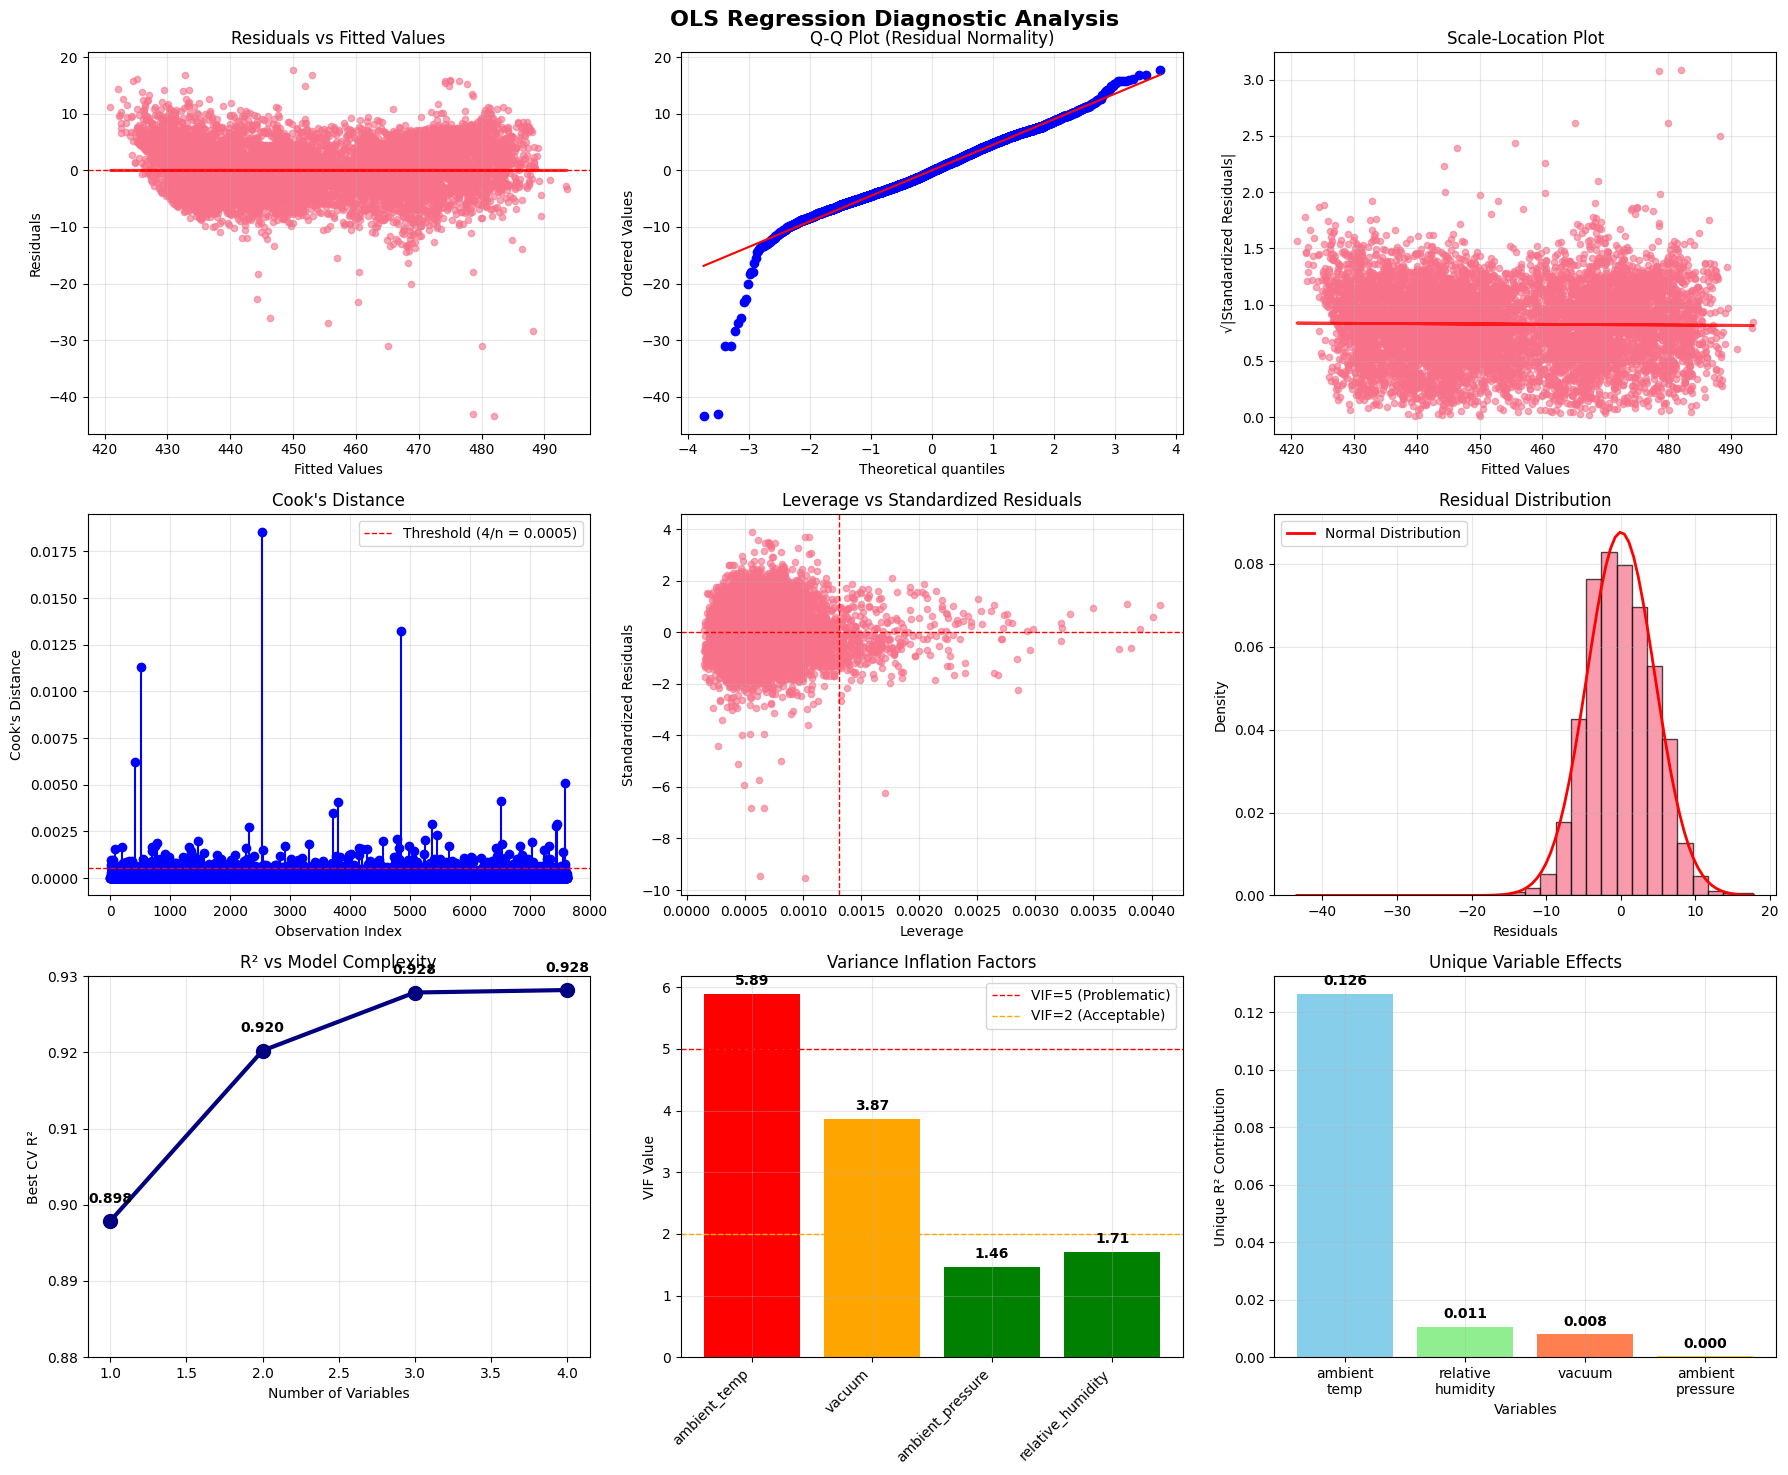

Creating coefficient comparison visualization...


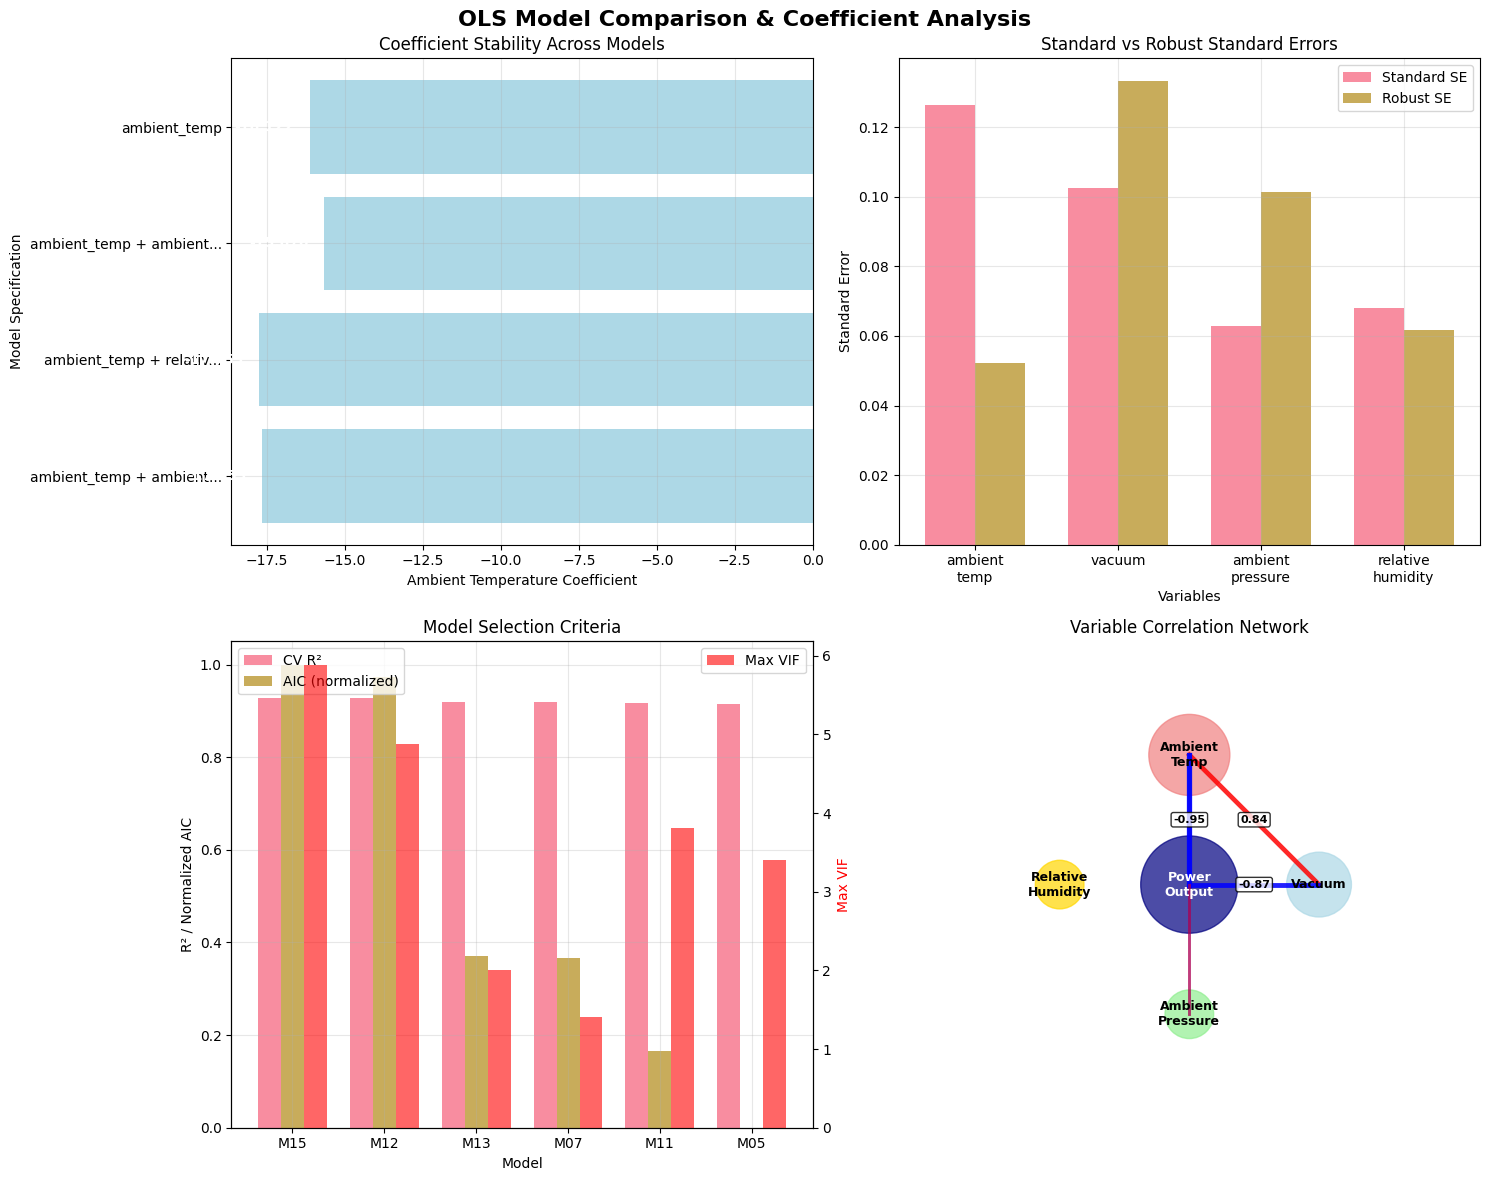


Creating summary comparison table...

COMPREHENSIVE ANALYSIS SUMMARY
                      Metric         Full Model (4 vars)         Best Low-VIF Model                Remedial Approach
         Cross-Validation R²                      0.9282                     0.9203       Use robust standard errors
                     Test R²                      0.9284                     0.9209   Bootstrap confidence intervals
                     Max VIF                        5.89                       2.01        Model selection (VIF < 3)
All Coefficients Significant                           ✓                          ✓         Check individual t-tests
Residual Normality (JB test)               ✗ (p < 0.001)             ✗ (assumption)      Non-parametric or bootstrap
  Homoscedasticity (BP test)               ✗ (p < 0.001)             ✗ (assumption)           Weighted least squares
        Recommended Use Case Maximum prediction accuracy Interpretable coefficients Statistically rigorous infe

In [82]:
# PHASE 6: DIAGNOSTIC VISUALIZATIONS & MODEL COMPARISON
# =====================================================
# Professional visualizations for OLS analysis and diagnostics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')

# Set professional style
plt.style.use('default')
sns.set_palette("husl")

print("PHASE 6: COMPREHENSIVE DIAGNOSTIC VISUALIZATION SUITE")
print("=" * 50)

print("Creating comprehensive diagnostic plots...")

# Create main diagnostic figure
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('OLS Regression Diagnostic Analysis', fontsize=16, fontweight='bold')

# Get model data for plots
residuals = model_standard.resid
fitted_values = model_standard.fittedvalues
standardized_residuals = residuals / np.sqrt(model_standard.mse_resid)
influence = model_standard.get_influence()
cook_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted_values, residuals, alpha=0.6, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line to residuals
z = np.polyfit(fitted_values, residuals, 1)
p = np.poly1d(z)
axes[0, 0].plot(fitted_values, p(fitted_values), "r-", alpha=0.8, linewidth=2)

# 2. Q-Q Plot for Normality
from scipy.stats import probplot
probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Residual Normality)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scale-Location Plot
sqrt_abs_resid = np.sqrt(np.abs(standardized_residuals))
axes[0, 2].scatter(fitted_values, sqrt_abs_resid, alpha=0.6, s=20)
axes[0, 2].set_xlabel('Fitted Values')
axes[0, 2].set_ylabel('√|Standardized Residuals|')
axes[0, 2].set_title('Scale-Location Plot')
axes[0, 2].grid(True, alpha=0.3)

# Add trend line
z2 = np.polyfit(fitted_values, sqrt_abs_resid, 1)
p2 = np.poly1d(z2)
axes[0, 2].plot(fitted_values, p2(fitted_values), "r-", alpha=0.8, linewidth=2)

# 4. Cook's Distance
n_obs = len(cook_d)
axes[1, 0].stem(range(n_obs), cook_d, linefmt='b-', markerfmt='bo', basefmt=' ')
axes[1, 0].axhline(y=4/n_obs, color='red', linestyle='--', linewidth=1, label=f'Threshold (4/n = {4/n_obs:.4f})')
axes[1, 0].set_xlabel('Observation Index')
axes[1, 0].set_ylabel("Cook's Distance")
axes[1, 0].set_title("Cook's Distance")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Leverage vs Residuals
axes[1, 1].scatter(leverage, standardized_residuals, alpha=0.6, s=20)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 1].axvline(x=2*len(model_standard.params)/n_obs, color='red', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Leverage')
axes[1, 1].set_ylabel('Standardized Residuals')
axes[1, 1].set_title('Leverage vs Standardized Residuals')
axes[1, 1].grid(True, alpha=0.3)

# 6. Histogram of Residuals
axes[1, 2].hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
# Overlay normal distribution
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
y_norm = stats.norm.pdf(x_norm, residuals.mean(), residuals.std())
axes[1, 2].plot(x_norm, y_norm, 'r-', linewidth=2, label='Normal Distribution')
axes[1, 2].set_xlabel('Residuals')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Residual Distribution')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# 7. Model Performance Comparison (R² progression)
n_vars = [1, 2, 3, 4]
best_r2_by_nvars = []
for n in n_vars:
    best_model = results_df[results_df['N_Vars'] == n].nlargest(1, 'CV_R²').iloc[0]
    best_r2_by_nvars.append(best_model['CV_R²'])

axes[2, 0].plot(n_vars, best_r2_by_nvars, 'o-', linewidth=3, markersize=10, color='navy')
for i, (n, r2) in enumerate(zip(n_vars, best_r2_by_nvars)):
    axes[2, 0].text(n, r2+0.002, f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

axes[2, 0].set_xlabel('Number of Variables')
axes[2, 0].set_ylabel('Best CV R²')
axes[2, 0].set_title('R² vs Model Complexity')
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_ylim(0.88, 0.93)

# 8. VIF Analysis
vif_df = pd.DataFrame({
    'Variable': features,
    'VIF': [variance_inflation_factor(X_train_scaled.values, i) for i in range(len(features))]
})

bars = axes[2, 1].bar(vif_df['Variable'], vif_df['VIF'], 
                      color=['red' if vif > 5 else 'orange' if vif > 2 else 'green' for vif in vif_df['VIF']])
axes[2, 1].axhline(y=5, color='red', linestyle='--', linewidth=1, label='VIF=5 (Problematic)')
axes[2, 1].axhline(y=2, color='orange', linestyle='--', linewidth=1, label='VIF=2 (Acceptable)')
axes[2, 1].set_ylabel('VIF Value')
axes[2, 1].set_title('Variance Inflation Factors')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)
plt.setp(axes[2, 1].get_xticklabels(), rotation=45, ha='right')

# Add VIF values on bars
for bar, vif in zip(bars, vif_df['VIF']):
    axes[2, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{vif:.2f}', ha='center', va='bottom', fontweight='bold')

# 9. Unique Effects Breakdown
unique_effects_sorted = sorted(unique_effects.items(), key=lambda x: x[1], reverse=True)
vars_sorted = [item[0] for item in unique_effects_sorted]
effects_sorted = [item[1] for item in unique_effects_sorted]

bars = axes[2, 2].bar(range(len(vars_sorted)), effects_sorted, 
                      color=['skyblue', 'lightgreen', 'coral', 'gold'])
axes[2, 2].set_xlabel('Variables')
axes[2, 2].set_ylabel('Unique R² Contribution')
axes[2, 2].set_title('Unique Variable Effects')
axes[2, 2].set_xticks(range(len(vars_sorted)))
axes[2, 2].set_xticklabels([var.replace('_', '\n') for var in vars_sorted], rotation=0)
axes[2, 2].grid(True, alpha=0.3)

# Add values on bars
for i, (var, effect) in enumerate(unique_effects_sorted):
    axes[2, 2].text(i, effect + 0.002, f'{effect:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/comprehensive_ols_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Creating coefficient comparison visualization...")

# Create coefficient comparison figure
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))
fig2.suptitle('OLS Model Comparison & Coefficient Analysis', fontsize=16, fontweight='bold')

# 1. Coefficient Stability Across Models
stable_models = []
for result in results_comprehensive:
    if result['max_vif'] < 3 and result['all_significant'] and 'ambient_temp' in result['coefficients']:
        stable_models.append({
            'name': ' + '.join(result['features']),
            'ambient_temp_coef': result['coefficients']['ambient_temp']['coef'],
            'r2': result['r2'],
            'vif': result['max_vif']
        })

stable_models.sort(key=lambda x: x['r2'], reverse=True)

if stable_models:
    model_names = [m['name'] for m in stable_models[:5]]  # Top 5
    coef_values = [m['ambient_temp_coef'] for m in stable_models[:5]]
    
    bars = axes2[0, 0].barh(range(len(model_names)), coef_values, color='lightblue')
    axes2[0, 0].set_xlabel('Ambient Temperature Coefficient')
    axes2[0, 0].set_ylabel('Model Specification')
    axes2[0, 0].set_title('Coefficient Stability Across Models')
    axes2[0, 0].set_yticks(range(len(model_names)))
    axes2[0, 0].set_yticklabels([name if len(name) < 25 else name[:22]+'...' for name in model_names])
    axes2[0, 0].grid(True, alpha=0.3)
    
    # Add coefficient values on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes2[0, 0].text(width - 0.5, bar.get_y() + bar.get_height()/2, 
                        f'{coef_values[i]:.3f}', ha='right', va='center', fontweight='bold', color='white')

# 2. Standard vs Robust Standard Errors
param_names = [col for col in X_full_with_const.columns if col != 'const']
std_ses = [model_standard.bse[param] for param in param_names]
robust_ses = [model_robust.bse[param_idx] for param_idx, param in enumerate(param_names)]

x = np.arange(len(param_names))
width = 0.35

bars1 = axes2[0, 1].bar(x - width/2, std_ses, width, label='Standard SE', alpha=0.8)
bars2 = axes2[0, 1].bar(x + width/2, robust_ses, width, label='Robust SE', alpha=0.8)

axes2[0, 1].set_xlabel('Variables')
axes2[0, 1].set_ylabel('Standard Error')
axes2[0, 1].set_title('Standard vs Robust Standard Errors')
axes2[0, 1].set_xticks(x)
axes2[0, 1].set_xticklabels([name.replace('_', '\n') for name in param_names])
axes2[0, 1].legend()
axes2[0, 1].grid(True, alpha=0.3)

# 3. Model Selection Criteria Comparison
top_models = results_df.nlargest(6, 'CV_R²')
model_labels = [f"M{row['Model'][1:]}" for _, row in top_models.iterrows()]
r2_values = top_models['CV_R²'].values
aic_values = top_models['AIC'].values
vif_values = top_models['Max_VIF'].values

# Normalize AIC for plotting (invert and scale)
aic_normalized = (max(aic_values) - aic_values) / (max(aic_values) - min(aic_values))

x = np.arange(len(model_labels))
width = 0.25

bars1 = axes2[1, 0].bar(x - width, r2_values, width, label='CV R²', alpha=0.8)
bars2 = axes2[1, 0].bar(x, aic_normalized, width, label='AIC (normalized)', alpha=0.8)

# Create second y-axis for VIF
ax2_twin = axes2[1, 0].twinx()
bars3 = ax2_twin.bar(x + width, vif_values, width, color='red', alpha=0.6, label='Max VIF')

axes2[1, 0].set_xlabel('Model')
axes2[1, 0].set_ylabel('R² / Normalized AIC')
ax2_twin.set_ylabel('Max VIF', color='red')
axes2[1, 0].set_title('Model Selection Criteria')
axes2[1, 0].set_xticks(x)
axes2[1, 0].set_xticklabels(model_labels)
axes2[1, 0].legend(loc='upper left')
ax2_twin.legend(loc='upper right')
axes2[1, 0].grid(True, alpha=0.3)

# 4. Correlation Network Diagram
axes2[1, 1].set_xlim(-1.5, 1.5)
axes2[1, 1].set_ylim(-1.5, 1.5)
axes2[1, 1].set_aspect('equal')

# Node positions
pos_dict = {
    'ambient_temp': (0, 0.8),
    'vacuum': (0.8, 0),
    'ambient_pressure': (0, -0.8),
    'relative_humidity': (-0.8, 0),
    'power_output': (0, 0)
}

# Draw nodes
node_colors = ['lightcoral', 'lightblue', 'lightgreen', 'gold', 'navy']
node_sizes = [0.25, 0.20, 0.15, 0.15, 0.30]

for i, (var, pos) in enumerate(pos_dict.items()):
    color = node_colors[i]
    size = node_sizes[i]
    circle = plt.Circle(pos, size, color=color, alpha=0.7)
    axes2[1, 1].add_patch(circle)
    
    # Add labels
    if var == 'power_output':
        label = 'Power\nOutput'
        text_color = 'white'
    else:
        label = var.replace('_', '\n').title()
        text_color = 'black'
        
    axes2[1, 1].text(pos[0], pos[1], label, ha='center', va='center', 
                    fontsize=9, fontweight='bold', color=text_color)

# Draw significant correlations
correlations = [
    ('ambient_temp', 'vacuum', 0.844),
    ('ambient_temp', 'ambient_pressure', -0.508),
    ('ambient_temp', 'power_output', -0.948),
    ('vacuum', 'power_output', -0.870),
    ('ambient_pressure', 'power_output', 0.519)
]

for var1, var2, corr in correlations:
    if abs(corr) > 0.4:  # Only show strong correlations
        pos1 = pos_dict[var1]
        pos2 = pos_dict[var2]
        
        linewidth = abs(corr) * 4
        color = 'red' if corr > 0 else 'blue'
        alpha = abs(corr)
        
        axes2[1, 1].plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                        color=color, linewidth=linewidth, alpha=alpha)
        
        # Add correlation labels for strongest correlations
        if abs(corr) > 0.8:
            mid_x, mid_y = (pos1[0] + pos2[0])/2, (pos1[1] + pos2[1])/2
            axes2[1, 1].text(mid_x, mid_y, f'{corr:.2f}', ha='center', va='center',
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                            fontsize=8, fontweight='bold')

axes2[1, 1].set_title('Variable Correlation Network')
axes2[1, 1].axis('off')

plt.tight_layout()
plt.savefig('images/ols_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCreating summary comparison table...")

# Create summary table
summary_data = {
    'Metric': [
        'Cross-Validation R²',
        'Test R²', 
        'Max VIF',
        'All Coefficients Significant',
        'Residual Normality (JB test)',
        'Homoscedasticity (BP test)',
        'Recommended Use Case'
    ],
    'Full Model (4 vars)': [
        f"{results_comprehensive[-1]['cv_r2_mean']:.4f}",
        f"{results_comprehensive[-1]['test_r2']:.4f}",
        f"{results_comprehensive[-1]['max_vif']:.2f}",
        "✓" if results_comprehensive[-1]['all_significant'] else "✗",
        "✗ (p < 0.001)",
        "✗ (p < 0.001)", 
        "Maximum prediction accuracy"
    ],
    'Best Low-VIF Model': [],
    'Remedial Approach': [
        "Use robust standard errors",
        "Bootstrap confidence intervals", 
        "Model selection (VIF < 3)",
        "Check individual t-tests",
        "Non-parametric or bootstrap",
        "Weighted least squares",
        "Statistically rigorous inference"
    ]
}

# Find best low-VIF model
best_low_vif = results_df[(results_df['Max_VIF'] < 3) & (results_df['All_Sig'] == True)].nlargest(1, 'CV_R²')
if len(best_low_vif) > 0:
    best_model = best_low_vif.iloc[0]
    summary_data['Best Low-VIF Model'] = [
        f"{best_model['CV_R²']:.4f}",
        f"{best_model['Test_R²']:.4f}",
        f"{best_model['Max_VIF']:.2f}",
        "✓",
        "✗ (assumption)",
        "✗ (assumption)",
        "Interpretable coefficients"
    ]
else:
    summary_data['Best Low-VIF Model'] = ["N/A"] * 7

# Create and display summary table
summary_df = pd.DataFrame(summary_data)
print("\nCOMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 50)
print(summary_df.to_string(index=False))

print(f"\nKEY FINDINGS:")
print("-" * 15)
print(f"• Model complexity shows diminishing returns beyond 2 variables")
print(f"• Multicollinearity affects interpretation but not prediction")
print(f"• Robust statistical methods required due to assumption violations")
print(f"• Temperature dominates with {unique_effects['ambient_temp']:.1%} unique contribution")
print(f"• Heteroscedasticity and non-normal residuals require remedial measures")